In [108]:
import numpy as np
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import json

def get_immediate_subdirectories(a_dir):
    return [name for name in os.listdir(a_dir) if os.path.isdir(os.path.join(a_dir, name))]

_DEBUG = True

def make_index():
    # Explore the raw folder and build a pandas frame with relevant run informations
    hashes = get_immediate_subdirectories('raw')
    all_keys = set()
    dict_of_dicts = {}

    for hash in hashes:
        with open('raw/{}/params'.format(hash), 'r') as outfile:
            params = json.load(outfile)
        dict_of_dicts[hash] = params

    database = pd.DataFrame.from_dict(dict_of_dicts).transpose()
    database.to_pickle('raw/parameters_database.pkl')
    database.to_string(open('raw/parameters_database_human_readable.txt', mode='w+'))
    database.to_csv(open('raw/parameters_database.csv', mode='w+'))
    print('Current index table : {}'.format(database))

def check_integrity(folder):
    try:
        with open('{}/exited_naturally'.format(folder), 'r') as f:
            pass
    except FileNotFoundError:
        print('Folder {} did not exit naturally, skip it'.format(folder))


def make_average_energy(folder):
    check_integrity(folder)

    with open('{}/params'.format(folder), 'r') as outfile:
        dict = json.load(outfile)
        n_seeds = dict['n_seeds']
        t_max = dict['t_max']
        test_every = dict['test_every']

    train_energy_blob = np.zeros((n_seeds, t_max//test_every+1))
    test_energy_blob = np.zeros((n_seeds, t_max // test_every + 1))

    for seed in range(n_seeds):
        train_energy_blob[seed] = np.load('{}/seed_{}/train_energy_acc.npy'.format(folder, seed))
        test_energy_blob[seed] = np.load('{}/seed_{}/test_energy_acc.npy'.format(folder, seed))

    train_mean = np.mean(train_energy_blob, axis=0)[1:]
    train_std = np.std(train_energy_blob, axis=0)[1:]

    test_mean = np.mean(test_energy_blob, axis=0)[1:]
    test_std = np.std(test_energy_blob, axis=0)[1:]

    np.save('{}/E_train_avg.npy'.format(folder), train_mean)
    np.save('{}/E_train_std.npy'.format(folder), train_std)

    np.save('{}/E_test_avg.npy'.format(folder), test_mean)
    np.save('{}/E_test_std.npy'.format(folder), test_std)


    plt.figure()
    plt.title(folder.split('/')[-1])
    plt.errorbar(np.arange(0, t_max, test_every), train_mean, yerr=train_std, label='Train')
    plt.errorbar(np.arange(0, t_max, test_every), test_mean, yerr=test_std, label='Test')
    plt.legend()
    plt.savefig('{}/energies.png'.format(folder))
    plt.close()


def make_average_mu(folder):
    check_integrity(folder)

    with open('{}/params'.format(folder), 'r') as outfile:
        dict = json.load(outfile)
        n_seeds = dict['n_seeds']
        t_max = dict['t_max']
        test_every = dict['test_every']

    mu_blob = np.zeros((n_seeds, t_max//test_every+1))


    for seed in range(n_seeds):
        mu_blob[seed] = np.load('{}/seed_{}/mu_acc.npy'.format(folder, seed))


    mu_mean = np.mean(mu_blob, axis=0)[1:]
    mu_std = np.std(mu_blob, axis=0)[1:]

    np.save('{}/mu_avg.npy'.format(folder), mu_mean)
    np.save('{}/mu_std.npy'.format(folder), mu_std)

    plt.figure()
    plt.title(folder.split('/')[-1])
    plt.errorbar(np.arange(0, t_max, test_every), mu_mean, yerr=mu_std)
    plt.savefig('{}/mus.png'.format(folder))
    plt.close()



def make_eigenvalues_diffmap(folder):
    check_integrity(folder)

    with open('{}/params'.format(folder), 'r') as outfile:
        dict = json.load(outfile)
        N = dict['n_neurons']
        n_seeds = dict['n_seeds']
        t_max = dict['t_max']
        test_every = dict['test_every']

    eigenvalues_blob = np.zeros((t_max // test_every + 1, N, n_seeds))
    mu_blob = np.zeros((t_max // test_every + 1, N, n_seeds))
    for seed in range(n_seeds):
        eigenvalues_blob[:, :, seed] = np.load('{}/seed_{}/eigenvalues_acc.npy'.format(folder, seed))
        mu_blob[:, :, seed] = np.repeat(np.load('{}/seed_{}/mu_acc.npy'.format(folder, seed)).reshape(-1, 1), N, axis=1)


    if _DEBUG:
        for t in range(1, 10):
            print(eigenvalues_blob[-t, :, 0].max().item(), eigenvalues_blob[-t, :, 0].min().item(), mu_blob[-t, 0, 0], mu_blob[-t, -1, 0], eigenvalues_blob[-t, :, 0].mean().item())

    eigenvalues_blob = mu_blob - eigenvalues_blob

    if _DEBUG:
        for t in range(1, 10):
            print(eigenvalues_blob[-t, :, 0].max().item(), eigenvalues_blob[-t, :, 0].min().item(), eigenvalues_blob[-t, :, 0].mean().item())


    # Make a "diffusion map" for the eigenvalues
    n_bins = 1000
    grouping = 10
    v_min, v_max = -5., 5.

    mixed_evs = np.clip(eigenvalues_blob.reshape(eigenvalues_blob.shape[0], -1), v_min, v_max)
    # print(np.min(mixed_evs), np.max(mixed_evs))
    # print(np.sum(mixed_evs == 0), np.sum(mixed_evs == 1.5))
    bounds = [v_min, v_max]
    diff_map = np.zeros((eigenvalues_blob.shape[0] // grouping +1, n_bins))

    for t in range(eigenvalues_blob.shape[0]):
        for ev in mixed_evs[t]:
            diff_map[t // grouping, int((n_bins-1) * (ev-bounds[0]) / (bounds[1] - bounds[0]))] += 1.

    for t in range(diff_map.shape[0]):
        diff_map[t] /= np.sum(diff_map[t])

    plt.figure()
    plt.imshow(diff_map[-100:].T, origin='lower', extent=[0, t_max, bounds[0], bounds[1]], aspect='auto')
    plt.title(folder.split('/')[-1])
    plt.savefig('{}/eigenvalues_diffmap.png'.format(folder))
    plt.close()



def parse_individual_subfolder(subfolder):
    # This function only acts as a container for other analysis routines (to keep things readable and modular)

    make_average_energy(subfolder)
    make_average_mu(subfolder)
    make_eigenvalues_diffmap(subfolder)



def post_run_parsing():
    make_index()
    exp_dirs = get_immediate_subdirectories('raw')
    for exp_dir in exp_dirs:
        print('Treating folder {}'.format(exp_dir))
        parse_individual_subfolder('raw/' + exp_dir)

post_run_parsing()

Current index table :                  alpha  beta beta_normalized gamma n_neurons n_samples  \
04336da277f609bd     0  2500               1     2        50         0   
04703120a401c0df    10  2500               1     0        50       500   
06fc33200b7de500     0  2500               1   3.5        50         0   
16a3691dc787dc40   100  2500               1    40        50       500   
17997e81004cbb60     0  2500               1   0.5        50         0   
1a6d744921e6d990  1000  2500               1    40        50       500   
1c3fab45577185af     1  2500               1    40        50       500   
1fe3054227ea29cf     0  2500               1   1.7        50         0   
4154fb48bf5dabf1     0  2500               1   100        50         0   
43f8b340c80e26f3     0  2500               1   0.6        50         0   
4d750eac11233d0e    10  2500               1    10        50       500   
4f50cd188d8ed3f3    10  2500               1   100        50       500   
51fa63eedf5712ea

Treating folder 17997e81004cbb60
2.4911625385284424 -2.6464741230010986 2.541406677916456 2.541406677916456 -1.8402934074401857e-08
2.3780887126922607 -2.6137046813964844 2.4515669165383676 2.4515669165383676 -2.6470515877008438e-08
2.381683588027954 -2.5762226581573486 2.4742007169140066 2.4742007169140066 3.1171366572380065e-08
2.4314751625061035 -2.500621795654297 2.5054480238341723 2.5054480238341723 6.146728992462158e-08
2.506871223449707 -2.4521303176879883 2.5580369588028793 2.5580369588028793 1.1548399925231934e-09
2.5566117763519287 -2.462254762649536 2.6039493008292465 2.6039493008292465 1.822132617235184e-08
2.528048038482666 -2.4817585945129395 2.578728806961059 2.578728806961059 5.690380930900574e-08
2.483158588409424 -2.5068883895874023 2.540796946981019 2.540796946981019 3.0286610126495364e-08
2.4596450328826904 -2.5887789726257324 2.5218676028296816 2.5218676028296816 1.817941665649414e-08
5.187880800917554 0.05024413938801375 2.54140669631939
5.065271597934852 0.073478

Treating folder f3d4cad4db59b5d3
0.5856947302818298 -0.6036970019340515 1.1013082939673602 1.1013082939673602 -1.735985279083252e-08
0.5921154618263245 -0.5893629193305969 1.1026658761177512 1.1026658761177512 7.457565516233444e-09
0.584750771522522 -0.5990280508995056 1.1011636909084062 1.1011636909084062 7.464550435543061e-09
0.6074801087379456 -0.6212734580039978 1.1014374264549183 1.1014374264549183 -8.754432201385498e-09
0.5961276888847351 -0.6150676608085632 1.1025689628060837 1.1025689628060837 -1.6205012798309326e-09
0.5759009122848511 -0.6169171333312988 1.1020077026258335 1.1020077026258335 7.264316082000732e-09
0.5960785746574402 -0.6096636056900024 1.1031752355406201 1.1031752355406201 2.2724270820617675e-09
0.5679852366447449 -0.6158445477485657 1.1022999039607908 1.1022999039607908 -1.434236764907837e-09
0.5797766447067261 -0.6288395524024963 1.1024789674037048 1.1024789674037048 1.6968697309494017e-08
1.7050052959014117 0.5156135636855304 1.101308311327213
1.692028795448

Treating folder a8f1dd5edcb4912d
0.9197353720664978 -0.9170198440551758 1.2379855570885694 1.2379855570885694 -3.3481046557426454e-09
0.9099332094192505 -0.8735661506652832 1.237378082924711 1.237378082924711 -1.1865049600601196e-08
0.9109804630279541 -0.9082843065261841 1.234703986862389 1.234703986862389 -4.76837158203125e-09
0.9093238711357117 -0.9246527552604675 1.2335500794657388 1.2335500794657388 1.7173588275909425e-08
0.8906094431877136 -0.9395657777786255 1.2305639548844571 1.2305639548844571 1.2069940567016602e-08
0.9015265107154846 -0.8701283931732178 1.2342589690293782 1.2342589690293782 2.905726432800293e-09
0.9203252792358398 -0.898025393486023 1.2379714883606128 1.2379714883606128 -7.450580596923828e-09
0.9416244626045227 -0.914513349533081 1.2416197815649712 1.2416197815649712 3.0547380447387693e-09
0.9562707543373108 -0.8811613917350769 1.2442618226075308 1.2442618226075308 2.961605787277222e-09
2.155005401143745 0.3182501850220716 1.2379855604366738
2.1109442335899944

Treating folder b58818dc2221563b
0.48059165477752686 -0.5859214663505554 1.0776268927259747 1.0776268927259747 -1.251697540283203e-08
0.49580344557762146 -0.5977497696876526 1.077185452446556 1.077185452446556 0.0
0.492221474647522 -0.5783019661903381 1.078495342000485 1.078495342000485 9.052455425262452e-09
0.4977608323097229 -0.5688461661338806 1.0799870220384824 1.0799870220384824 1.330394297838211e-08
0.5379612445831299 -0.6376409530639648 1.0837153866086016 1.0837153866086016 -1.993030309677124e-09
0.5133311748504639 -0.555403470993042 1.0798500430718487 1.0798500430718487 -4.917383193969727e-09
0.49795466661453247 -0.5687252879142761 1.0775926889166898 1.0775926889166898 -8.419156074523925e-09
0.49139562249183655 -0.5575534105300903 1.0769164236271462 1.0769164236271462 8.00006091594696e-09
0.4830520749092102 -0.5742031931877136 1.0757113761793162 1.0757113761793162 4.0046870708465575e-09
1.66354835907653 0.5970352379484478 1.07762690524295
1.6749352221342086 0.5813820068689346 1

In [109]:
def get_siblings(ref_hash, traversal_key):
    # Take the hash of a reference experiment and return list of hashes such that only 'traversal_key' differs
    db = pd.read_pickle('raw/parameters_database.pkl')
    all_keys = list(db.keys())
    hashes = db.index.values.tolist()
    siblings = []
    values = []

    with open('raw/{}/params'.format(ref_hash), 'r') as outfile:
        ref_params = json.load(outfile)

    for hash in hashes:
        is_sibling = True
        with open('raw/{}/params'.format(hash), 'r') as outfile:
            params = json.load(outfile)
        for key in all_keys:
            if params[key] != ref_params[key] and key not in [traversal_key, 't_max', 'n_threads', 'n_seeds', 'test_every']:
                is_sibling = False
                break
        if is_sibling:
            siblings.append(hash)
            values.append(params[traversal_key])

    # Correctly sort the directories in increasing values of the param
    sorter = np.argsort(values)

    siblings = np.array(siblings)[sorter]
    values = np.array(values)[sorter]

    print('To vary parameter {} in {}, visit {}'.format(traversal_key, values, siblings))


    return siblings, values
    
hashs, params = get_siblings('04336da277f609bd', 'gamma')

To vary parameter gamma in [  0.2   0.5   0.6   0.9   1.    1.1   1.2   1.7   2.    3.5   4.   10.
 100. ], visit ['7dd0a314a0296953' '17997e81004cbb60' '43f8b340c80e26f3'
 'd8e9fceb12a92d9d' 'f32da4303804adb4' 'e3f1f9a49fc5cc5f'
 'c1320d47c32b128c' '1fe3054227ea29cf' '04336da277f609bd'
 '06fc33200b7de500' 'a8f1dd5edcb4912d' 'f3d4cad4db59b5d3'
 '4154fb48bf5dabf1']


In [133]:
import matplotlib.pyplot as plt
from scipy import optimize

def fit_rho(p, x):
    return p * np.sqrt((x+2) * (2-x))

def error_rho(p,x,y):
    return (fit_rho(p,x) - y) 

def fit_rho_lambda2(p, x):
    return p * np.sqrt((2.+np.sqrt(x))*(2.-np.sqrt(x))/ x)
def error_rho_lambda2(p,x,y):
    return (fit_rho_lambda2(p,x) - y)

def theoretical_rho(x):
    return np.sqrt(x * (L-x))

def theoretical_mu_null_alpha(gamma):
    # If Gamma < gamma^c = 1, spin glass phase, mu == 4
    if gamma > 1.:
        return np.sqrt(gamma) * (1. + 1. / np.sqrt(gamma)) **2
    else:
        return 4.

Treating folder 7dd0a314a0296953 with gamma = 0.2


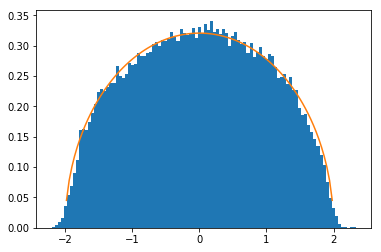

Measured J2 : 0.9819429419308557 pm 0.9944992124513554, theory 1


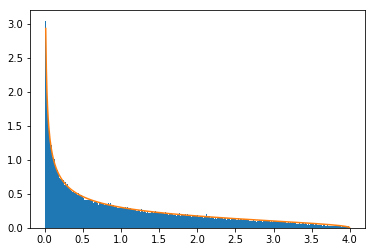

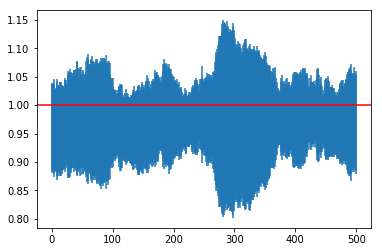

For m : theory 1.0, exp : 0.9489100047772424 pm 0.050263908647086894
Treating folder 17997e81004cbb60 with gamma = 0.5


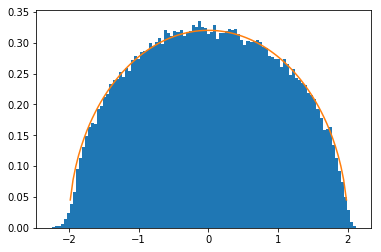

Measured J2 : 0.9827459789797066 pm 0.9915397462182823, theory 1


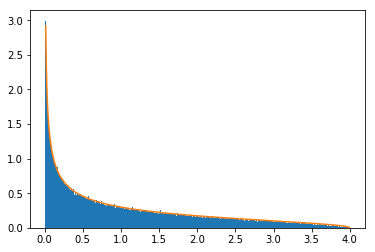

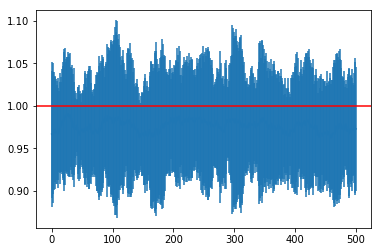

For m : theory 1.0, exp : 0.9667836919179379 pm 0.027093693831427713
Treating folder 43f8b340c80e26f3 with gamma = 0.6


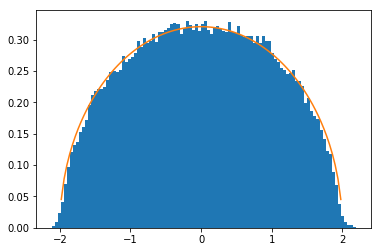

Measured J2 : 0.9740058423749047 pm 0.9822077766601827, theory 1


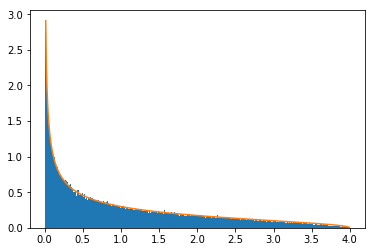

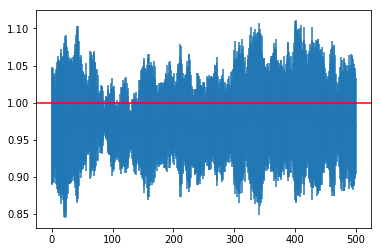

For m : theory 1.0, exp : 0.9721956154601569 pm 0.024538448978891132
Treating folder d8e9fceb12a92d9d with gamma = 0.9


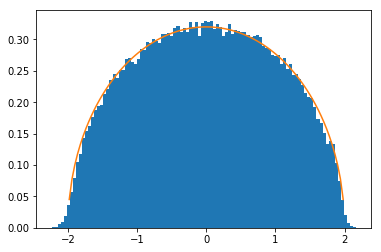

Measured J2 : 0.9869110637665617 pm 0.9975638753419521, theory 1


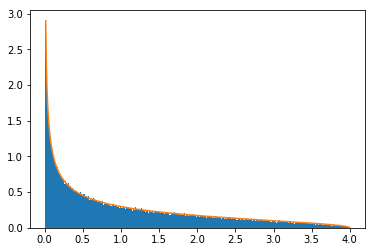

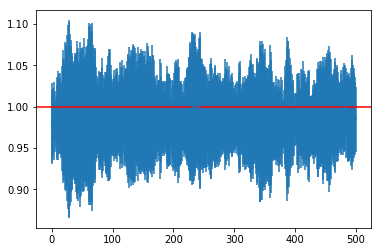

For m : theory 1.0, exp : 0.984989590797272 pm 0.016821797679584912
Treating folder f32da4303804adb4 with gamma = 1.0


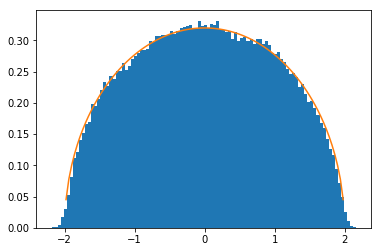

Measured J2 : 0.9857765521714166 pm 0.9936203298754298, theory 1


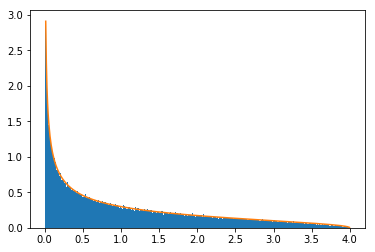

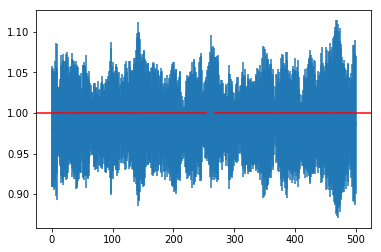

For m : theory 1.0, exp : 0.9882389839369182 pm 0.01717429559416815
Treating folder e3f1f9a49fc5cc5f with gamma = 1.1


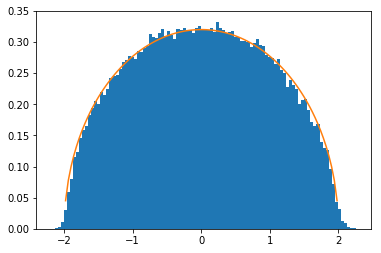

Measured J2 : 0.9826215396890875 pm 0.9945865084488836, theory 1


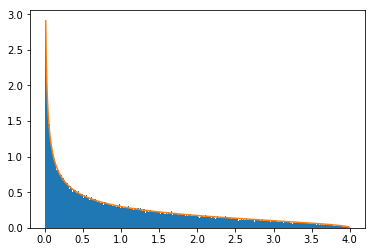

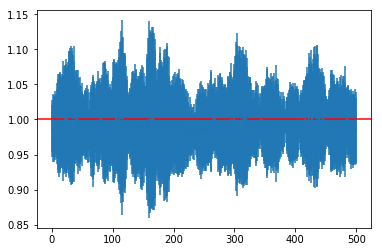

For m : theory 1.000567859353936, exp : 0.9938973012584135 pm 0.016949253704588593
Treating folder c1320d47c32b128c with gamma = 1.2


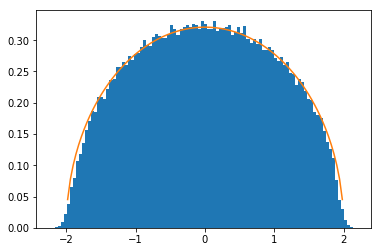

Measured J2 : 0.9714457536449649 pm 0.9776176847237745, theory 1


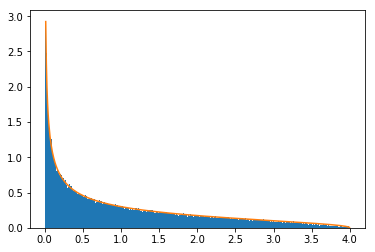

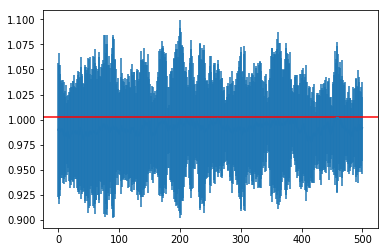

For m : theory 1.0020790110464024, exp : 0.9955119129228417 pm 0.017604395342356402
Treating folder 1fe3054227ea29cf with gamma = 1.7


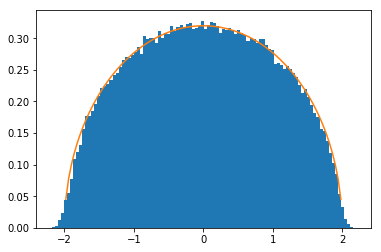

Measured J2 : 0.991088560526308 pm 1.0000462840375521, theory 1


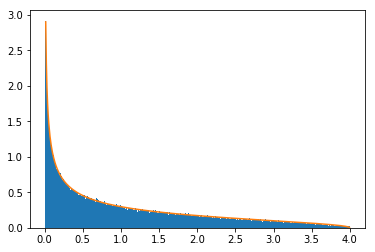

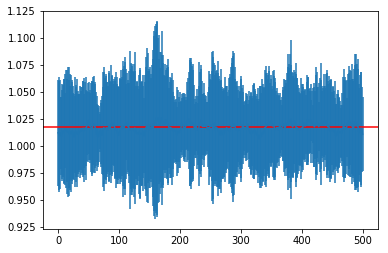

For m : theory 1.017701367471975, exp : 1.021565940119118 pm 0.021677206796705314
Treating folder 04336da277f609bd with gamma = 2.0


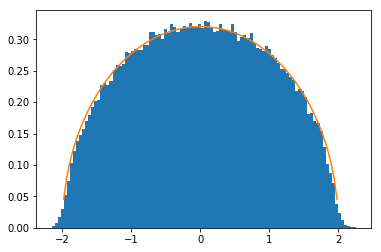

Measured J2 : 0.9831420756378795 pm 0.993423022646476, theory 1


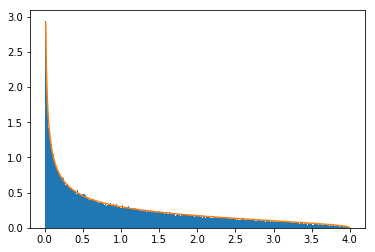

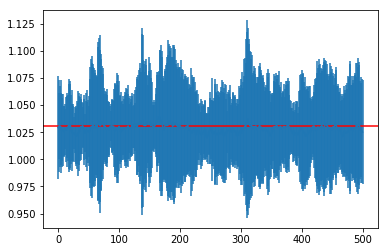

For m : theory 1.0303300858899107, exp : 1.0355974694949608 pm 0.026899425792327375
Treating folder 06fc33200b7de500 with gamma = 3.5


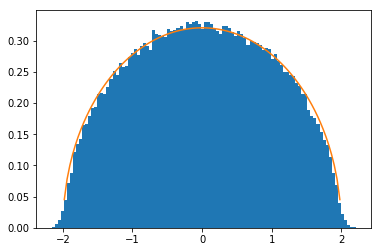

Measured J2 : 0.9781433094164693 pm 0.9926342135130598, theory 1


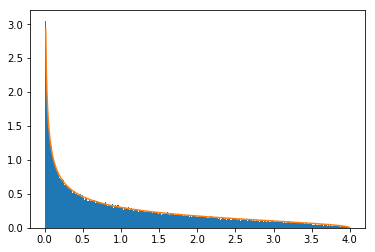

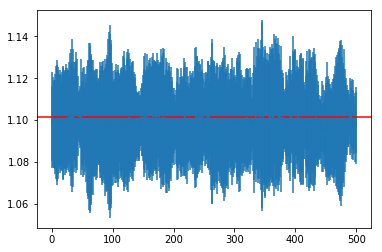

For m : theory 1.1013377943029548, exp : 1.1123141720733671 pm 0.04514523630878175
Treating folder a8f1dd5edcb4912d with gamma = 4.0


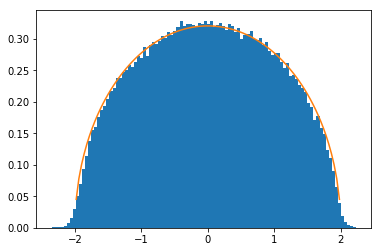

Measured J2 : 0.9822774037489376 pm 0.9961760470673067, theory 1


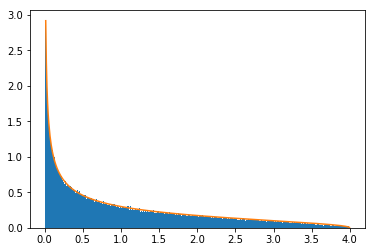

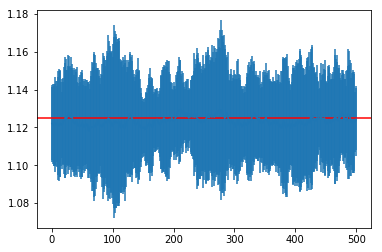

For m : theory 1.125, exp : 1.1389414118384849 pm 0.05055449033790392
Treating folder f3d4cad4db59b5d3 with gamma = 10.0


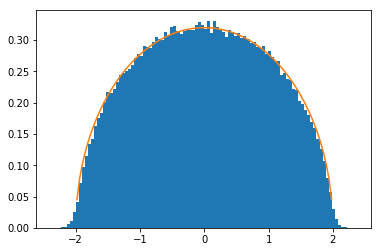

Measured J2 : 0.989189839988173 pm 1.0007586295592525, theory 1


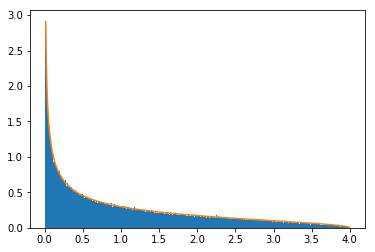

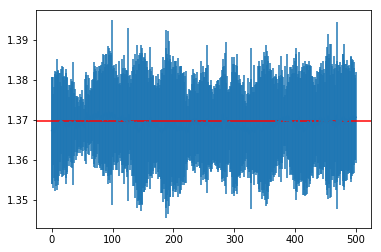

For m : theory 1.3696263565463045, exp : 1.3971705082892267 pm 0.0955820019991444
Treating folder 4154fb48bf5dabf1 with gamma = 100.0


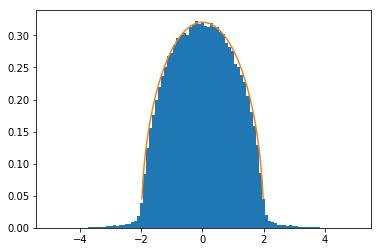

Measured J2 : 1.0630916998684872 pm 1.2600298302793689, theory 1


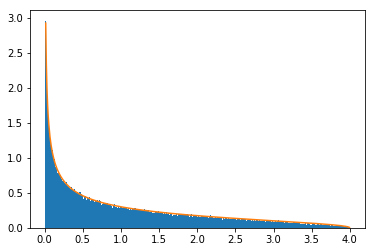

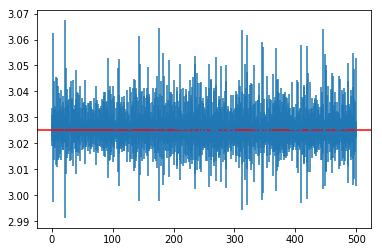

For m : theory 3.0250000000000004, exp : 3.1370703643725686 pm 0.3436726766136072


In [135]:
plop, blob = [], []
for path, gamma in zip(hashs, params):
    print('Treating folder {} with gamma = {}'.format(path, gamma))
    
    with open('raw/{}/params'.format(path), 'r') as outfile:
        dict = json.load(outfile)
        N = dict['n_neurons']
        n_seeds = dict['n_seeds']
        t_max = dict['t_max']
        test_every = dict['test_every']

    eigenvalues_blob = np.zeros((t_max // test_every + 1, N, n_seeds))
    mu_blob = np.zeros((t_max // test_every + 1, n_seeds))
    for seed in range(n_seeds):
        eigenvalues_blob[:, :, seed] = np.load('raw/{}/seed_{}/eigenvalues_acc.npy'.format(path, seed))
        mu_blob[:, seed] = np.load('raw/{}/seed_{}/mu_acc.npy'.format(path, seed))
    
    # Need to rescale J as in calculations we started from J/sqrt(gamma)
    eigenvalues_blob *= np.sqrt(gamma)
    mu_blob *= np.sqrt(gamma) 
    mu_blob += 2    

    # Discard the first half of the values for each run
    eigenvalues_blob = eigenvalues_blob[len(eigenvalues_blob) // 2:].flatten()
    mu_mean = mu_blob[len(mu_blob)//2:].mean(axis=1)
    mu_std = mu_blob[len(mu_blob)//2:].std(axis=1)
    

    points = np.linspace(-1.99,1.99, 500)  
    
    plt.figure()
    # Purposefully ignore values beyond +2, -2 so fit can work
    n, bins, _ = plt.hist(eigenvalues_blob, density=True, bins=100, range=(-2, 2))
    centers = (bins[:-1] + bins[1:]) / 2.
    p0 = [0.3]
    p1, success = optimize.leastsq(error_rho, p0[:], args=(centers, n))
    
    plt.clf()
    _, _, _ = plt.hist(eigenvalues_blob, density=True, bins=100,)
    plt.plot(centers, fit_rho(p1, centers)) # theoretical curve, with correct normalization
    plt.show()
    
    # Quadratic coupling intensity J2 : 
    J2 = np.mean(eigenvalues_blob ** 2)
    J2_std = np.std(eigenvalues_blob ** 2)
    print('Measured J2 : {} pm {}, theory 1'.format(J2, J2_std))
   


    plt.figure()
    n, bins, _ = plt.hist(eigenvalues_blob**2, density=True, bins=500, range=(0.01, 4))
    centers = (bins[:-1] + bins[1:]) / 2.
    p0 = [0.3]
    p1, success = optimize.leastsq(error_rho_lambda2, p0[:], args=(centers, n))
    plt.plot(centers, fit_rho_lambda2(p1, centers))
    plt.show()
    
    plop.append(np.mean(mu_mean))
    blob.append(theoretical_mu_null_alpha(gamma))
    
    # Divide by 4 to plot m instead of mu
    plt.figure()
    plt.errorbar(x=range(len(mu_mean)), y=mu_mean / 4., yerr=mu_std)
    plt.axhline(y=theoretical_mu_null_alpha(gamma) / 4., c='r')
    plt.show()
    
    print('For m : theory {}, exp : {} pm {}'.format(theoretical_mu_null_alpha(gamma)/ 4., np.mean(mu_blob)/ 4., np.std(mu_blob)/ 4.))
    
#     # Make a smoothed over 10 periods version :
#     tmp = mu_mean[::10][:-1]
#     std = mu_std[::10][:-1]
#     print(len(tmp), len(std))
    
#     n_pts = len(tmp)
#     for i in range(1,10):
#         tmp += mu_mean[i::10][:n_pts] 
#         std += mu_std[i::10][:n_pts] 
        
#     tmp /= 10.
#     std /= 10.*np.sqrt(10.)
    
#     plt.figure()
#     plt.errorbar(x=range(len(tmp)), y=tmp / 4., yerr=std)
#     plt.axhline(y=theoretical_mu_null_alpha(gamma) / 4., c='r')
#     plt.show()

[3.885542127542666, 3.90502707596708, 3.901145904332318, 3.943849249925191, 3.9554596874190593, 3.9778073286813407, 3.9664000840448024, 4.066810553059414, 4.113468454194193, 4.397668807045122, 4.493488010068241, 5.476146445631466, 12.106407575684434] [4.0, 4.0, 4.0, 4.0, 4.0, 4.002271437415744, 4.00831604418561, 4.0708054698879, 4.121320343559643, 4.405351177211819, 4.5, 5.478505426185218, 12.100000000000001]


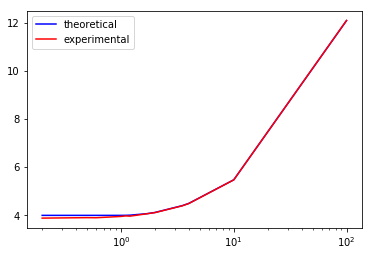

In [137]:
print(plop, blob)

plt.figure()
plt.semilogx(params, blob, c='b', label='theoretical')
plt.semilogx(params, plop, c='r', label='experimental')
plt.legend()
plt.show()
